In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Load standardized data

In [2]:
X_scaled_df = pd.read_csv('../dataset/user_scaled.csv')
id_col = 'visitorid'
print(X_scaled_df.skew())
cols_features = ['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']
X_final = X_scaled_df[[id_col] + cols_features]

visitorid         -0.026269
Recency            0.100507
Frequency          1.367438
Monetary           0.021475
Conversion_Rate    0.046189
dtype: float64


## 2.PCA projection

In [3]:
# Giữ lại 95% thông tin
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_final[cols_features])

# 3. Kiểm tra lại kết quả
print(f"Số lượng PC giữ lại: {pca.n_components_}")
print(f"Tỷ lệ phương sai giải thích: {pca.explained_variance_ratio_}")
print(f"Tổng thông tin giữ lại: {sum(pca.explained_variance_ratio_):.2f}")
X_pca.shape

Số lượng PC giữ lại: 4
Tỷ lệ phương sai giải thích: [0.33933047 0.26582658 0.22788678 0.16695618]
Tổng thông tin giữ lại: 1.00


(11719, 4)

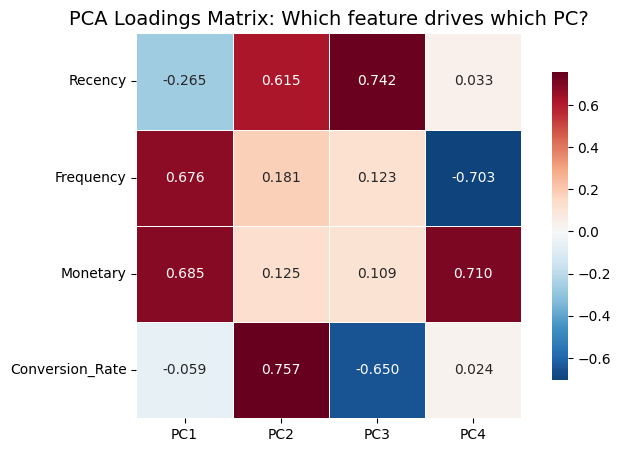

In [4]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3', 'PC4'], 
    index=cols_features
)
plt.figure(figsize=(8, 5))

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.3f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('PCA Loadings Matrix: Which feature drives which PC?', fontsize=14)
plt.yticks(rotation=0) 
plt.show()

PC1 (rục Sức Mạnh Mua Sắm - Overall Value): cao Khách VIP, thấp Khách mới/giá trị thấp

PC2 (Trục Khách Cũ Hiệu Quả - Efficient Dormancy): One-hit Wonders chốt đơn nhanh (Conversion cao) nhưng lặn lâu (dùng quen items, thường mua luôn khi cần)

PC3 (Trục Rời Bỏ - Churn Risk): Khách hàng đã mất/ rời bỏ

PC4 (Trục Phong Cách Chi Tiêu - Shopping Behavior): 
PC4 Dương: M cao, F thấp  Người săn hàng hiệu / Mua sỉ
PC4 Âm   : M thấp, F cao  Người mua lặt vặt, nhu cầu txuyen

## 3. K-means & Evaluation

Running experiments to find the optimal K...
k=2: Inertia = 33954 | Silhouette = 0.3560
k=3: Inertia = 27132 | Silhouette = 0.2594
k=4: Inertia = 23376 | Silhouette = 0.2446
k=5: Inertia = 20668 | Silhouette = 0.2430
k=6: Inertia = 18244 | Silhouette = 0.2524
k=7: Inertia = 16417 | Silhouette = 0.2528
k=8: Inertia = 14963 | Silhouette = 0.2589
k=9: Inertia = 13705 | Silhouette = 0.2632
k=10: Inertia = 12726 | Silhouette = 0.2562


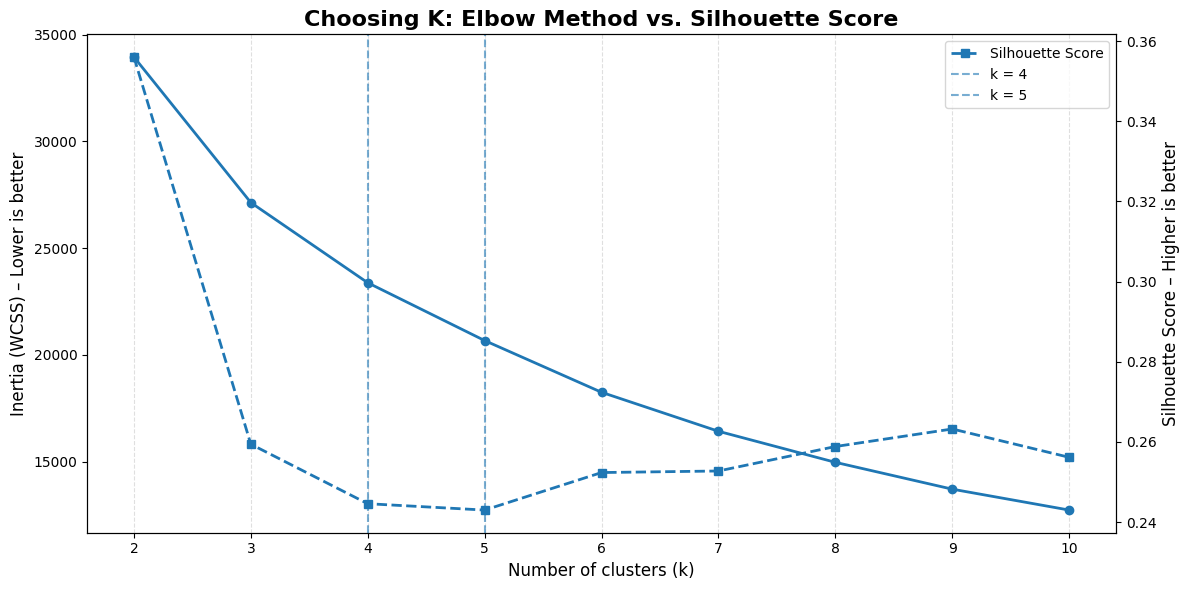

In [5]:
# 1. We test a range of cluster numbers (k) from 2 to 10.
# 2. For each k, we calculate two metrics:
#    - Inertia (WCSS): Measures how compact the clusters are (Lower is better).
#      We look for the "Elbow" point where the decrease slows down.
#    - Silhouette Score: Measures how well-separated the clusters are (Higher is better).
#      We look for peaks close to +1.
# 3. We plot both metrics on a dual-axis chart to find the best trade-off.
# -----------------------------
wcss = []                # Inertia (Elbow) – lower is better
silhouette_avg = []      # Silhouette – higher is better
k_range = range(2, 11)

print("Running experiments to find the optimal K...")

# -----------------------------
# Training loop
# -----------------------------
for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=10
    )
    
    labels = kmeans.fit_predict(X_pca)
    
    # Elbow metric
    wcss.append(kmeans.inertia_)
    
    # Silhouette metric
    score = silhouette_score(X_pca, labels)
    silhouette_avg.append(score)
    
    print(f"k={k}: Inertia = {kmeans.inertia_:.0f} | Silhouette = {score:.4f}")

# -----------------------------
# Plot: Dual-axis (single plot)
# -----------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis – Inertia (WCSS)
ax1.set_xlabel('Number of clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (WCSS) – Lower is better', fontsize=12)
ax1.plot(
    k_range, wcss,
    marker='o',
    linestyle='-',
    linewidth=2,
    label='Inertia'
)
ax1.set_xticks(list(k_range))
ax1.grid(True, axis='x', linestyle='--', alpha=0.4)

# Right axis – Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score – Higher is better', fontsize=12)
ax2.plot(
    k_range, silhouette_avg,
    marker='s',
    linestyle='--',
    linewidth=2,
    label='Silhouette Score'
)

# Title
plt.title(
    'Choosing K: Elbow Method vs. Silhouette Score',
    fontsize=16,
    fontweight='bold'
)

# Highlight potential optimal K values
plt.axvline(x=4, linestyle='--', alpha=0.6, label='k = 4')
plt.axvline(x=5, linestyle='--', alpha=0.6, label='k = 5')

plt.legend()
fig.tight_layout()
plt.show()


(11719, 6)
--- CLUSTER PROFILES (Average Values) ---


,Cluster,Recency,Frequency,Monetary,Conversion_Rate,Count,Percent
0,0,-0.59,-0.52,-0.23,-0.98,2741,23.4
1,1,-0.64,-0.53,0.12,0.75,2839,24.2
2,2,-0.11,1.88,0.61,0.02,2564,21.9
3,3,1.04,-0.53,-0.36,0.14,3575,30.5


<class 'sklearn.decomposition._pca.PCA'>

--- PCA COORDINATES PER CLUSTER ---


,PC1,PC2
Cluster,,
0,-0.30,-1.23
1,-0.15,0.10
2,1.72,0.36
3,-0.88,0.60


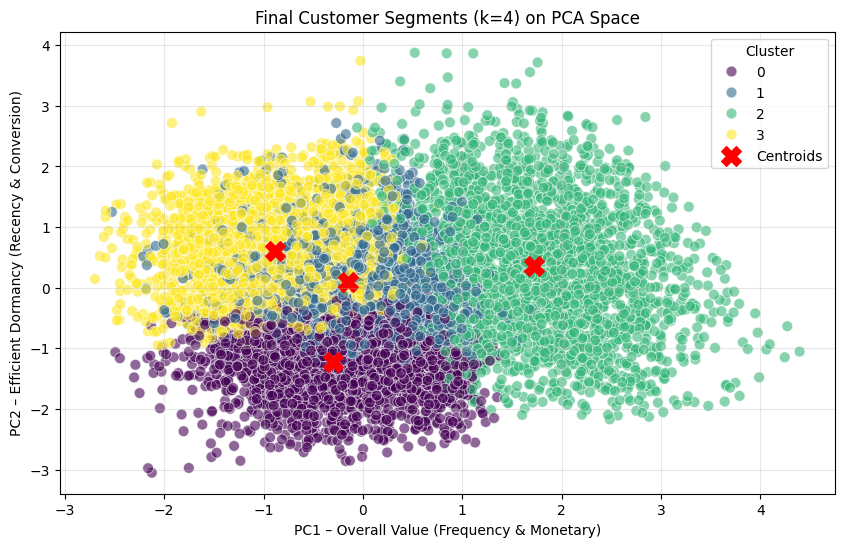

In [6]:
# 1. RUN FINAL K-MEANS WITH K=4
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
# Fit vào X_pca
cluster_labels = kmeans_final.fit_predict(X_pca)

# Gán label vào X_final
X_final_1 = X_final.copy() # Tạo bản copy để tránh SettingWithCopyWarning
X_final_1['Cluster'] = cluster_labels
print(X_final_1.shape)


# 2. CLUSTER PROFILING
# Tính trung bình các chỉ số RFM cho từng cụm
cluster_profile = X_final_1.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']].mean().reset_index()

# Tính số lượng khách hàng trong từng cụm
cluster_size = X_final_1.groupby('Cluster').size().reset_index(name='Count')

# Gộp bảng và hiển thị
profile_table = cluster_profile.merge(cluster_size, on='Cluster')

# Tính tỷ lệ % cho dễ nhìn (Optional)
profile_table['Percent'] = (profile_table['Count'] / profile_table['Count'].sum() * 100).round(1)

print("--- CLUSTER PROFILES (Average Values) ---")
display(profile_table.round(2))

# 3. VISUALIZE THE SEGMENTS
print(type(pca))

# Tạo tên cột PC1, PC2, PC3... dựa trên số chiều của X_pca
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

# PCA + cluster label đã align:
X_pca_df = pd.DataFrame(X_pca, columns=pc_columns)

# Thêm cột Cluster vào X_pca_df để vẽ
X_pca_df['Cluster'] = X_final_1['Cluster'].values

# --- A. Xem trung bình tọa độ PCA của từng cụm ---
print("\n--- PCA COORDINATES PER CLUSTER ---")
pca_profile = X_pca_df.groupby('Cluster')[['PC1', 'PC2']].mean() # Chỉ cần xem PC1, PC2 là chính
display(pca_profile.round(2))

# --- B. Vẽ biểu đồ Scatter Plot ---
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=X_pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    alpha=0.6,
    s=60 # Kích thước điểm
)

# Vẽ tâm cụm (Centroids) lên biểu đồ cho chuyên nghiệp hơn
centroids = kmeans_final.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

plt.title('Final Customer Segments (k=4) on PCA Space')
plt.xlabel('PC1 – Overall Value (Frequency & Monetary)') # Đặt tên theo ý nghĩa bạn đã phân tích
plt.ylabel('PC2 – Efficient Dormancy (Recency & Conversion)') # Đặt tên theo ý nghĩa bạn đã phân tích
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()


## 4. Profile & Name

In [7]:
# 4. BUSINESS MAPPING & MERGING (CUSTOM SEGMENTS)

segment_names = {
    2: 'Loyal Customers',           # Frequency & Monetary cao
    1: 'Promising / New',           # Conversion cao, mới
    0: 'Low Value / Low Engagement',# Active-ish nhưng giá trị thấp
    3: 'Hibernating / At Risk'      # Lâu không mua, nhưng có thể có chiến lược tái kích hoạt
}

# Map vào DataFrame chính
X_final_1['Segment'] = X_final_1['Cluster'].map(segment_names)

# Tính profile
final_report = (
    X_final_1
    .groupby('Segment')[['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']]
    .mean()
    .round(2)
)

# Thêm số lượng khách
final_report['Count'] = X_final_1['Segment'].value_counts()

print("--- FINAL CUSTOMER SEGMENTATION PROFILES ---")

from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "MyLightPalette",
    ["#f0f0f0", "#fff176", "#81c784"]
)

display(
    final_report
    .style
    .background_gradient(
        cmap=my_cmap,
        subset=['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']
    )
    .format("{:.2f}")
)

--- FINAL CUSTOMER SEGMENTATION PROFILES ---


,Recency,Frequency,Monetary,Conversion_Rate,Count
Segment,,,,,
Hibernating / At Risk,1.04,-0.53,-0.36,0.14,3575.00
Low Value / Low Engagement,-0.59,-0.52,-0.23,-0.98,2741.00
Loyal Customers,-0.11,1.88,0.61,0.02,2564.00
Promising / New,-0.64,-0.53,0.12,0.75,2839.00


In [8]:
customers_df = pd.read_csv('../dataset/customers.csv')

# Giả sử customers_df và X_final_1 cùng số dòng & thứ tự
X_final_1 = X_final_1.copy()
X_final_1['visitorid'] = customers_df['visitorid'].values

merged_df = customers_df.merge(
    X_final_1[['visitorid', 'Cluster']],
    on='visitorid',
    how='inner'
)

segment_names = {
    2: 'Loyal Customers',
    1: 'Promising / New',
    0: 'Low Value / Low Engagement',
    3: 'Hibernating / At Risk'
}

merged_df['Segment'] = merged_df['Cluster'].map(segment_names)

real_profile_mean = (
    merged_df
    .groupby('Segment')[cols_features]
    .agg(['mean', 'count'])
)

print("--- REAL BUSINESS PROFILE (MEAN VALUES) ---")

display(
    real_profile_mean
    .xs('mean', axis=1, level=1)
    .style
    .format({
        'Recency': '{:.1f} days',
        'Frequency': '{:.2f} times',
        'Monetary': '${:,.2f}',
        'Conversion_Rate': '{:.2%}'
    })
    .background_gradient(cmap='YlGn')
)


--- REAL BUSINESS PROFILE (MEAN VALUES) ---


,Recency,Frequency,Monetary,Conversion_Rate
Segment,,,,
Hibernating / At Risk,106.4 days,1.00 times,"$82,514.19",23.03%
Low Value / Low Engagement,41.9 days,1.00 times,"$100,268.34",9.94%
Loyal Customers,61.2 days,5.18 times,"$564,328.66",24.24%
Promising / New,40.1 days,1.00 times,"$148,508.72",32.09%


In [9]:
merged_df[cols_features].describe()

,Recency,Frequency,Monetary,Conversion_Rate
count,11719.000000,11719.000000,1.171900e+04,11719.000000
mean,65.361806,1.916290,2.080705e+05,0.224284
std,39.560055,8.850529,1.169617e+06,0.165694
min,1.000000,1.000000,2.568000e+03,0.000935
25%,31.000000,1.000000,2.748000e+04,0.111111
50%,64.000000,1.000000,6.084000e+04,0.200000
75%,99.000000,1.000000,1.740000e+05,0.333333
max,138.000000,559.000000,7.396297e+07,5.000000


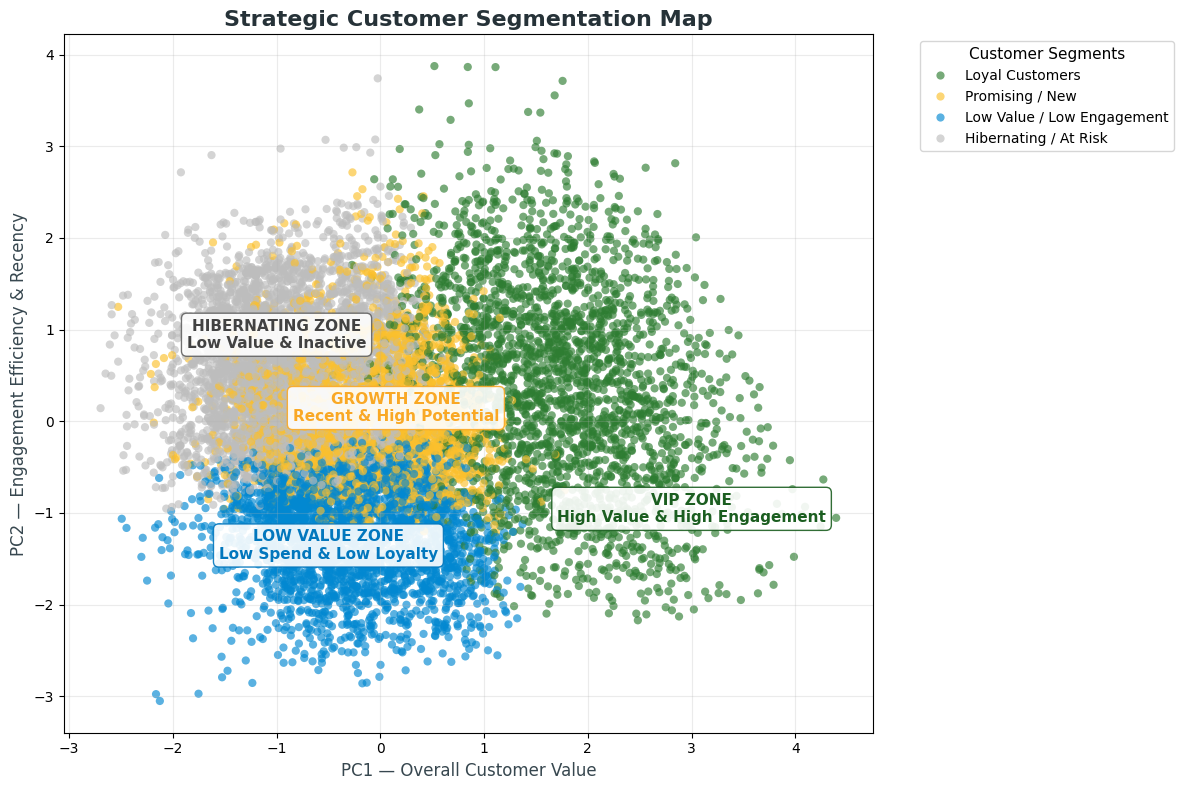

In [14]:
# =========================================================
# 6. PLOT FINAL STRATEGIC CHART (FIXED & CLEAN)
# =========================================================

plt.figure(figsize=(12, 8))

# 1. Business-meaning color palette (KEYS MUST MATCH Segment VALUES)
custom_palette = {
    'Loyal Customers': '#2E7D32',        # Dark green
    'Low Value / Low Engagement': '#0288D1',    # Blue
    'Promising / New': '#FBC02D',        # Gold
    'Hibernating / At Risk': '#BDBDBD'      # Neutral gray
}

# 2. ENSURE Segment column exists & is aligned
# (X_pca_df index was already aligned earlier with X_final_1)
X_pca_df = X_pca_df.copy()
X_pca_df['Segment'] = X_final_1['Segment']

# 3. Scatter plot
sns.scatterplot(
    data=X_pca_df,
    x='PC1',
    y='PC2',
    hue='Segment',                 # IMPORTANT: use column name
    palette=custom_palette,
    alpha=0.65,
    s=35,
    edgecolor='none'
)

# 4. Titles & axis labels
plt.title(
    'Strategic Customer Segmentation Map',
    fontsize=16,
    fontweight='bold',
    color='#263238'
)

plt.xlabel(
    'PC1 — Overall Customer Value',
    fontsize=12,
    color='#37474F'
)

plt.ylabel(
    'PC2 — Engagement Efficiency & Recency',
    fontsize=12,
    color='#37474F'
)

# 5. Legend styling
plt.legend(
    title='Customer Segments',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True
)

plt.grid(True, alpha=0.25)

# =========================================================
# 6. STRATEGIC ZONE ANNOTATIONS
# (Coordinates are PCA-scale dependent – presentation tuned)
# =========================================================

plt.text(
    x=3.0,
    y=-1.1,
    s="VIP ZONE\nHigh Value & High Engagement",
    fontsize=11,
    fontweight='bold',
    color='#1B5E20',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#1B5E20', alpha=0.9)
)

plt.text(
    x=0.15,
    y=0.0,
    s="GROWTH ZONE\nRecent & High Potential",
    fontsize=11,
    fontweight='bold',
    color='#F9A825',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#F9A825', alpha=0.9)
)

plt.text(
    x=-0.5,
    y=-1.5,
    s="LOW VALUE ZONE\nLow Spend & Low Loyalty",
    fontsize=11,
    fontweight='bold',
    color='#0277BD',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#0277BD', alpha=0.9)
)

plt.text(
    x=-1.0,
    y=0.8,
    s="HIBERNATING ZONE\nLow Value & Inactive",
    fontsize=11,
    fontweight='bold',
    color='#424242',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#616161', alpha=0.9)
)

plt.tight_layout()
plt.show()
